In [1]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

Could not import rpy package
Could not import r-package RCIT


In [2]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def color_map(lst, cmap):
    result = []
    minima = min(lst)
    maxima = max(lst)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    c = mapper.to_rgba(lst)
    
    for i in range(len(lst)):
        result.append('#{:02x}{:02x}{:02x}{:02x}'.format(int(c[i,0]*255), int(c[i,1]*255) , int(c[i,2]*255), int(c[i,3]*255)))
        
    return(result)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

def neighbour_vote(df,lat,lon):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if not df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values.size == 0:           
            result.append(np.asscalar(df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values))
        else:
            result.append(-1)   
            
        
    return(np.array(result))

def neighbour_vote_class(dic,lat,lon):
    shift = [[-0.25,0.25],[-0.25,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    #shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if lon > 180: lon -= 360
        if (lat + y, lon + x) in class_dic.keys():
            result.append(class_dic[(lat + y, lon + x)])   
    return(np.array(result))

In [3]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [4]:
d = Data('precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [5]:
result = pf.deseasonalize(np.array(result))

In [6]:
result = np.array(result)

In [7]:
#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

In [8]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

#lon_temp = df["lons"].values
#lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
#df["lons"] = lon_temp

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

clusters = clustering.labels_

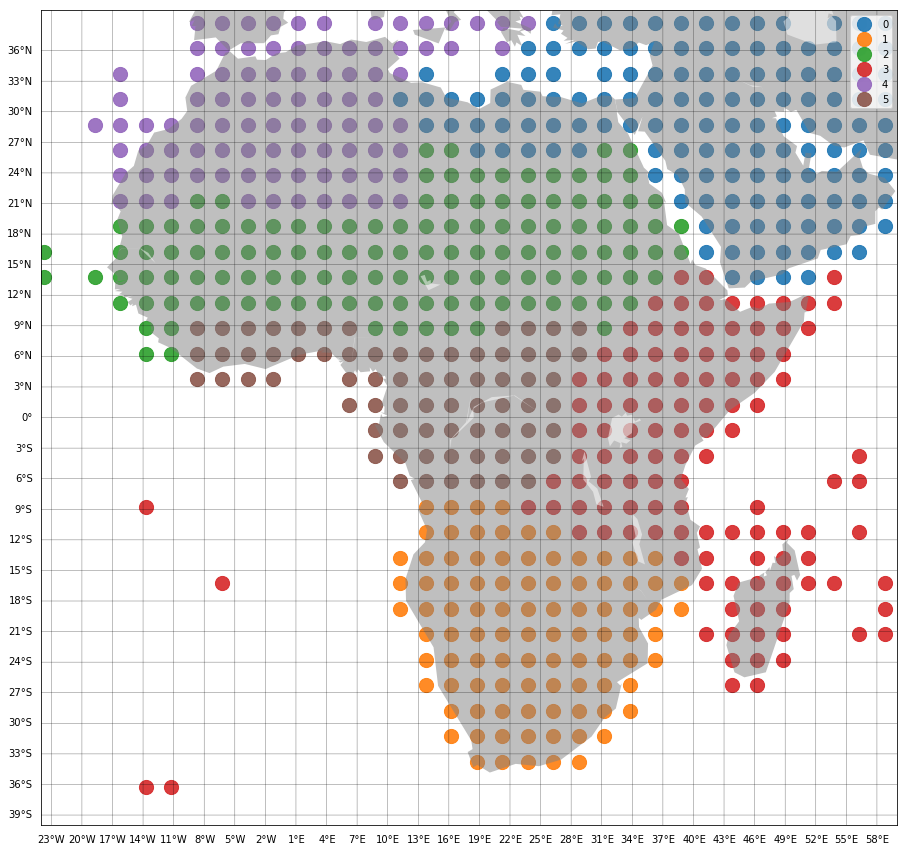

In [9]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [10]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

In [24]:
df.iloc[391,:]

lons        31.25
lats        18.75
clusters     2.00
Name: 391, dtype: float64

In [23]:
df[np.logical_and(df['lons'] == 43.75,df['lats'] == 23.75)]


,lons,lats,clusters
518,43.75,23.75,0


In [11]:
df

,lons,lats,clusters
0,-23.75,16.25,2
1,-23.75,13.75,2
2,-18.75,28.75,4
3,-18.75,13.75,2
4,-16.25,33.75,4
...,...,...,...
630,58.75,21.25,0
631,58.75,18.75,0
632,58.75,-16.25,3
633,58.75,-18.75,3


In [25]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

In [31]:
df_cluster.to_csv("df_cluster.csv")

In [26]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 7 link(s):
        (3 0): pval = 0.00000 | val = 0.289
        (4 0): pval = 0.00000 | val = 0.269
        (2 0): pval = 0.00000 | val = 0.219
        (0 -1): pval = 0.00003 | val = 0.144
        (1 -1): pval = 0.00357 | val = 0.101
        (5 0): pval = 0.02021 | val = 0.081
        (1 0): pval = 0.02578 | val = 0.077

    Variable 1 has 4 link(s):
        (1 -1): pval = 0.00000 | val = 0.215
        (3 -1): pval = 0.00701 | val = -0.094
        (2 -2): pval = 0.01444 | val = -0.085
        (0 0): pval = 0.02578 | val = 0.077

    Variable 2 has 7 link(s):
        (5 0): pval = 0.00000 | val = 0.346
        (4 0): pval = 0.00000 | val = 0.323
        (2 -1): pval = 0.00000 | val = 0.295
        (0 0): pval = 0.00000 | val = 0.219
        (5 -1): pval = 0.00039 | val = -0.123
        (3 0): pval = 0.00202 | val = 0.107
        (4 -2): pval = 0.02925 | val = -0.076

    Variable 3 has 6 link(s):
        (3 -1): pval = 0.00000 | 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1c468352e8>)

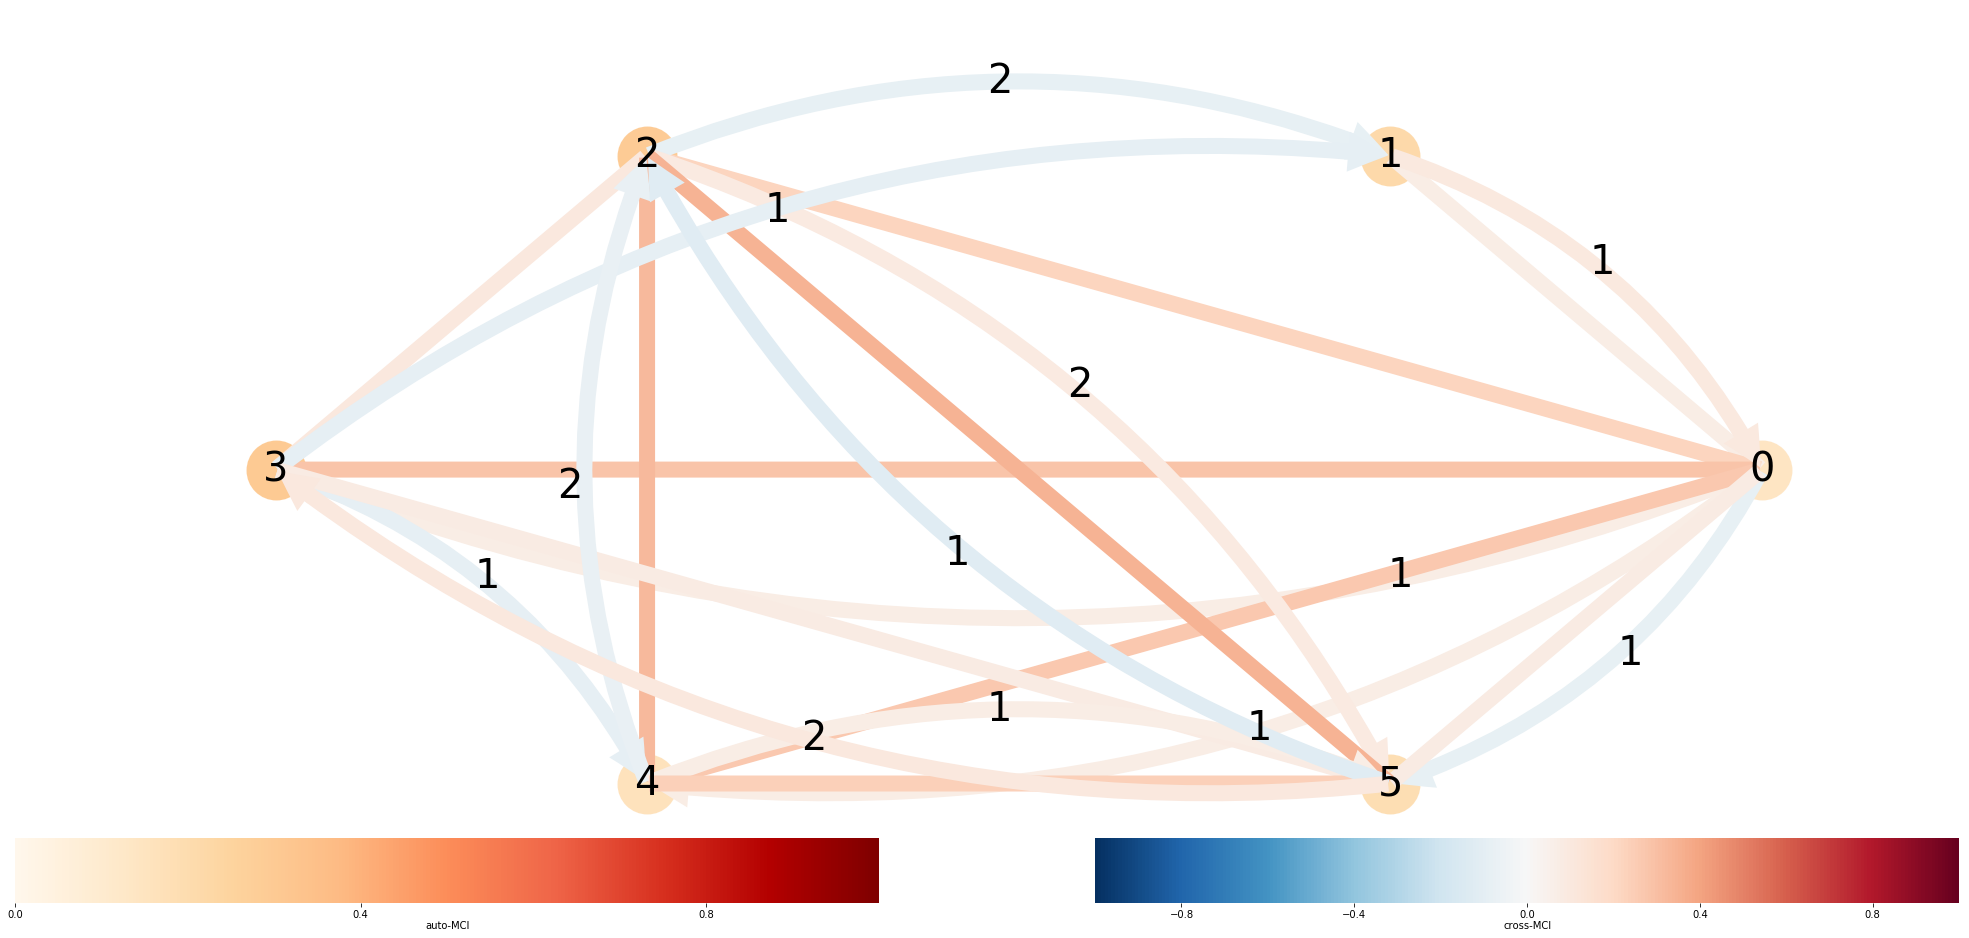

In [27]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [28]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 4 link(s):
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.289
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.269
        (2 0): pval = 0.00000 | qval = 0.00000 | val = 0.219
        (0 -1): pval = 0.00003 | qval = 0.00035 | val = 0.144

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.215

    Variable 2 has 6 link(s):
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.346
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.323
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.295
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.219
        (5 -1): pval = 0.00039 | qval = 0.00399 | val = -0.123
        (3 0): pval = 0.00202 | qval = 0.00202 | val = 0.107

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.304
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.289
        (2 0): pval = 0.00202 | qval =

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1c46f93748>)

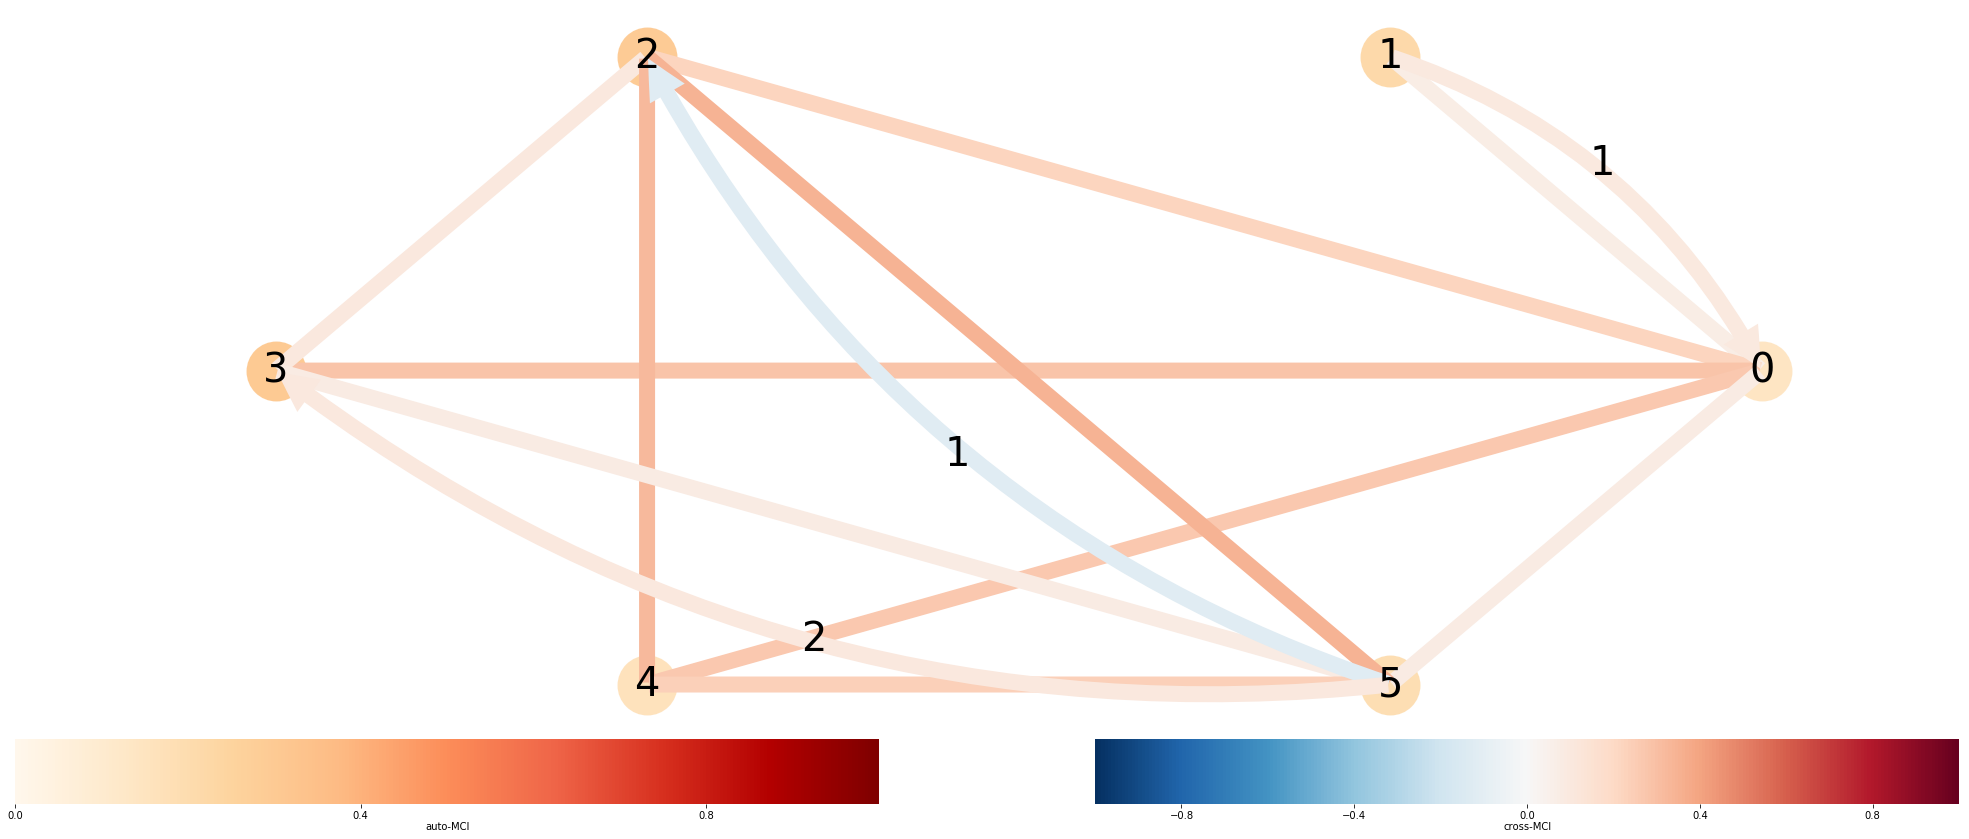

In [29]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

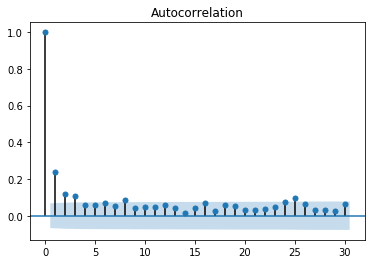

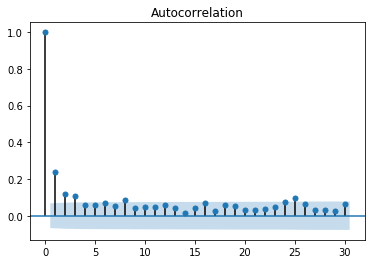

In [20]:
plot_acf(df_cluster.iloc[:,5].values)

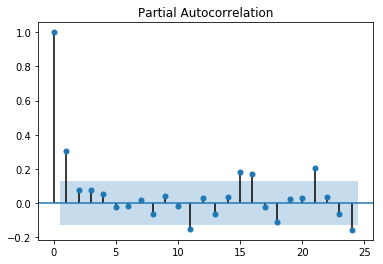

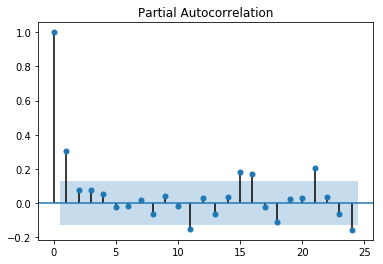

In [27]:
plot_pacf(df_cluster.iloc[:,1].values)

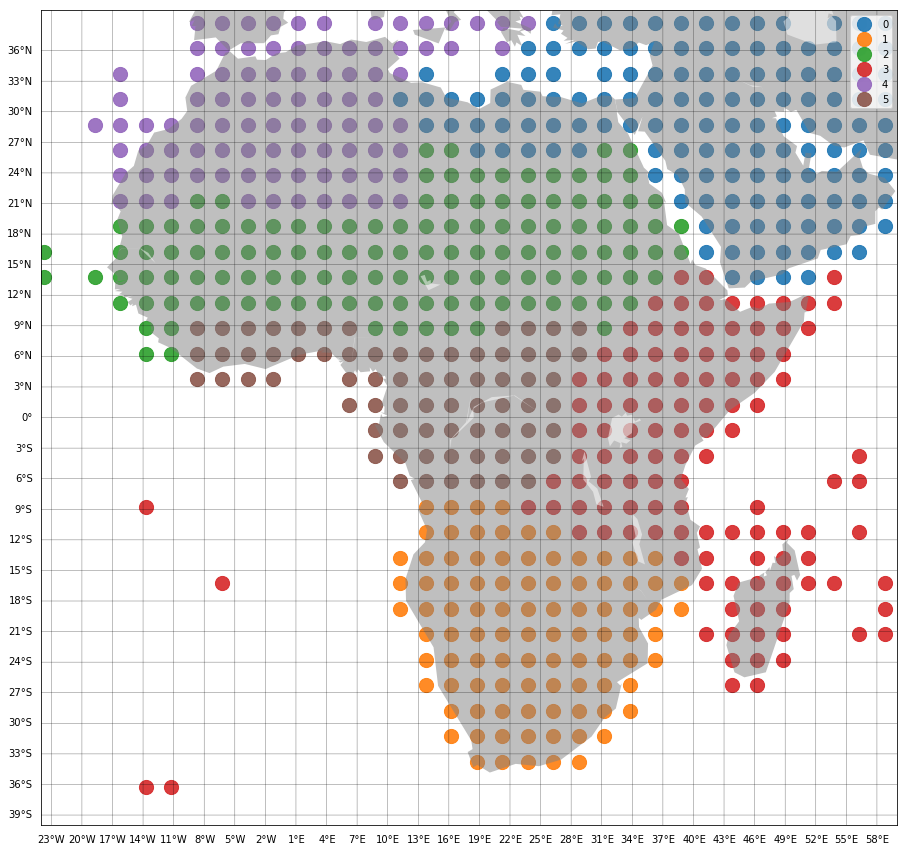

In [41]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

d = Data('precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

result = pf.deseasonalize(np.array(result))

result = np.array(result)

temp = np.array(result)

clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})


lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

clusters = clustering.labels_

df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [62]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    print(pca_model.explained_variance_ratio_)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,1])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

[0.15251035 0.08728778 0.05497023 0.05383234 0.0441419  0.03624696]
[0.19471183 0.1122102  0.07457394 0.05494347 0.04989499 0.0460934 ]
[0.1772455  0.06727616 0.04802849 0.04395956 0.03863205 0.03608806]
[0.14789288 0.0785492  0.05228582 0.04500508 0.03641208 0.03388943]
[0.19550402 0.10494547 0.08700486 0.06435264 0.05323361 0.04177215]
[0.17373752 0.08434206 0.06579084 0.04961569 0.0405939  0.03564974]


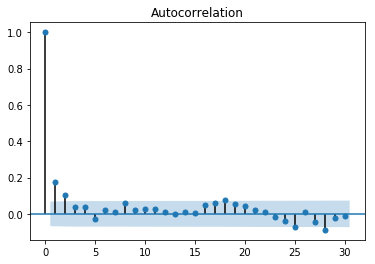

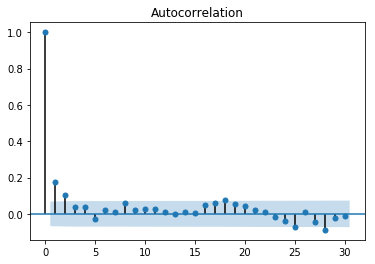

In [71]:
plot_acf(df_cluster.iloc[:,5].values)

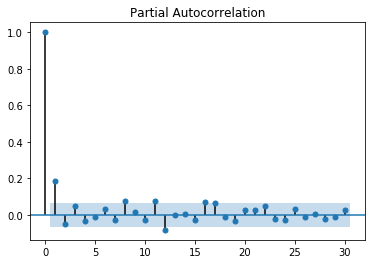

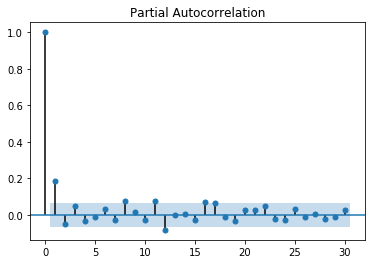

In [11]:
plot_pacf(df_cluster.iloc[:,4].values)

In [ ]:
df_clu